In [1]:
%pylab inline
import pandas as pd
import pylab as pl
pl.rcParams['figure.figsize'] = (10.0, 8.0)
autumn()

Populating the interactive namespace from numpy and matplotlib


In [2]:
def get_grid(data, step=0.1):
    x_min, x_max = data.x.min() - 1, data.x.max() + 1
    y_min, y_max = data.y.min() - 1, data.y.max() + 1
    return np.meshgrid(np.arange(x_min, x_max, step),
                       np.arange(y_min, y_max, step))

from sklearn.cross_validation import cross_val_score

def get_score(X, y, cl):
    return cross_val_score(cl, X, y, cv=5, scoring='mean_squared_error').mean()

def show_classifier(X, y, cl,
                    feature_modifier=lambda x: x,
                    proba=True,
                    print_score=False,
                    grid=None):
    if not grid:
        xs, ys = get_grid(X)
    else:
        xs, ys = grid
    xys = c_[ravel(xs), ravel(ys)]
    cl.fit(feature_modifier(X), y)
    if print_score:
        print("MSE = {}".format(get_score(feature_modifier(X), y, cl)))
    if proba:
        predicted = cl.predict_proba(feature_modifier(pd.DataFrame(xys, columns=('x', 'y'))))[:,1].reshape(xs.shape)
    else:
        predicted = cl.predict(feature_modifier(pd.DataFrame(xys, columns=('x', 'y')))).reshape(xs.shape)
    pcolormesh(xs, ys, predicted)
    scatter(X.x, X.y, c=y, alpha=0.5)
    autoscale(tight=True)
    return cl

# Линейные классификаторы

$$a(x) = sign(\left<x, w\right> - w_0)$$

# SVM

$$ \sum_{i=0}^l (1-M_i(w, w_0))_+ + \frac{1}{2C} ||w||^2 \to min $$

### Линейно разделимая выборка

$$\begin{cases}\frac{||w||^2}2\rightarrow\min \\ M_i(w, w_0) \ge 1,\ i=1, \dots, l\end{cases}$$

In [3]:
def show_SVM(data, target, clf, grid=None, show_borders=False):
    trained_clf = show_classifier(data,
                                  target,
                                  clf,
                                  grid=grid,
                                  proba=False);
    xx = np.linspace(data.x.min() - 1, data.x.max() + 1)
    w = trained_clf.coef_[0]
    a = -w[0] / w[1]
    yy = a * xx - (trained_clf.intercept_[0]) / w[1]
    plot(xx, yy, 'k-')
    if show_borders:
        b = trained_clf.support_vectors_[0]
        yy_down = a * xx + (b[1] - a * b[0])
        b = trained_clf.support_vectors_[-1]
        yy_up = a * xx + (b[1] - a * b[0])
        plot(xx, yy_down, 'k--')
        plot(xx, yy_up, 'k--')
    plt.scatter(trained_clf.support_vectors_[:, 0],
                trained_clf.support_vectors_[:, 1],
                s=80, facecolors='none');

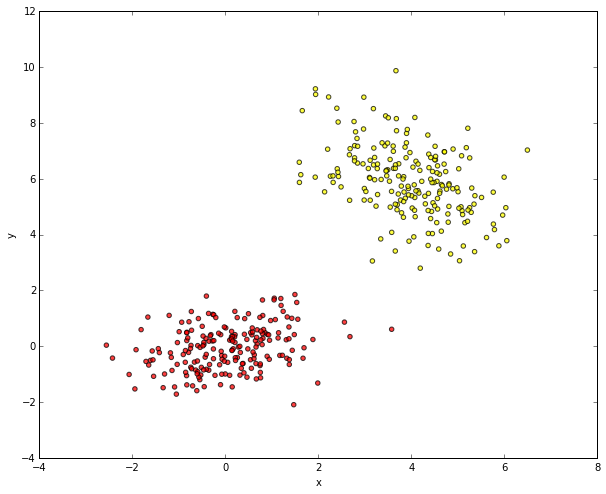

In [4]:
from sklearn.svm import SVC # SVC использует libsvm для решения двойственной задачи SVM и поддерживает ядра
# можно было обойтись LinearSVC, но из него нельзя получить опорные векторы
random = np.random.RandomState(19)
n = 200
df1 = pd.DataFrame(data=random.multivariate_normal((0,0), [[1, 0.3], [0.3, 0.7]], n), columns=['x', 'y'])
df1['target'] = 0
df2 = pd.DataFrame(data=random.multivariate_normal((4,6), [[1, -0.5], [-0.5, 1.6]], n), columns=['x', 'y'])
df2['target'] = 1
separable_data = pd.concat([df1, df2], ignore_index=True)
separable_data.plot(kind='scatter', x='x', y='y', c='target', colormap='autumn', alpha=0.75, colorbar=False);

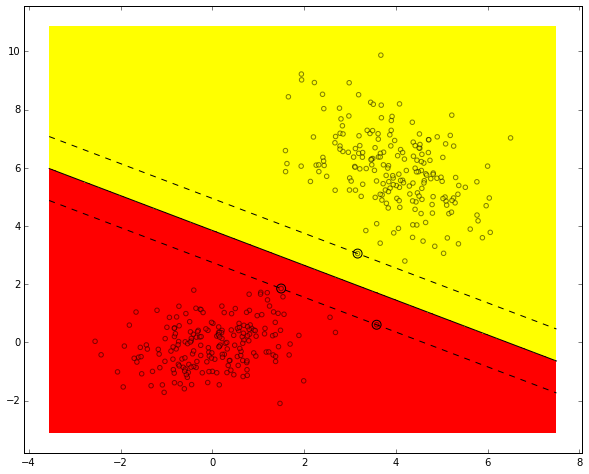

In [5]:
separable_grid = get_grid(separable_data, 0.03)
show_SVM(separable_data[['x', 'y']],
         separable_data.target, 
         SVC(kernel='linear'),
         grid=separable_grid,
         show_borders=True)

### Линейно неразделимая выборка

$$\begin{cases} \frac{||w||^2}2+ C \sum_\limits{i=1}^l \xi_i \to \min  \\ M_i(w, w_0) \ge 1-\xi_i,\ i=1, \dots, l \\ \xi_i\geqslant 0,\ i=1, \dots, l\end{cases}$$

In [6]:
show_SVM(features,
         data.target, 
         SVC(kernel='linear'),
         grid=big_grid)

NameError: name 'features' is not defined

### Двойственная задача

Перед нами по-прежнему задача выпуклого программирования. Ей эквивалентна двойственная задача (здесь она уже немного преобразована): $$ \begin{cases} -\sum\limits_{i=1}^l\lambda_i+\frac12\sum\limits_{i=1}^l\sum\limits_{j=1}^l\lambda_i\lambda_j y_i y_j\left<x_i, x_j\right>\rightarrow\min \\ \forall i: 0 \le \lambda_i \le C \\ \sum\limits_{i=1}^l\lambda_i y_i = 0 \end{cases} $$ $\lambda_i$ - двойственные переменные. Если $\lambda_i=0$, то ограничение на отступ $i$-го объекта неактивно (выполнено строгое неравенство), объект верно классифицируется «с запасом» и не влияет на разделяющую плоскость.

Классификатор можно выразить через решение двойственной задачи: $$\tilde y(x)=\operatorname{sign}(\mathscr{L}(\sum\limits_{i=1}^l\lambda_i y_i\left<x_i, x_j\right>-w_0\bigr)$$ $w_0$ можно найти, пользуясь равенством $1$ отступов опорных объектов.


### Ядровой переход

Распространённые ядра:

Полиномиальные $$K(x_1,x_2)=\left<x_1, x_2\right>^d
\\K(x_1,x_2)=(\left<x_1, x_2\right>+1)^d$$
Сигмоидное
$$K(x_1,x_2)=\operatorname{th}(\gamma\left<x_1, x_2\right>+r)$$
Ядро RBF(radial basis functions)
$$K(x_1,x_2)=e^{-\gamma||x_1-x_2||^2}$$

In [7]:
figure(figsize=(15,15))
grid = get_grid(features, 0.05)
for i in range(1,4):
    for j in range(1,4):
        subplot(3, 3, 3 * (i - 1) + j)
        C = 10**(i-2)
        gamma = 10**(j-2)
        show_classifier(features, data.target, 
                        SVC(kernel='rbf', C=C, gamma=gamma),
                        proba=False,
                        grid=grid);        
        title('C={:.1f}; gamma={:.1f}'.format(C, gamma))

NameError: name 'features' is not defined